<a href="https://colab.research.google.com/github/mashtakovmm/polycode2022/blob/no_morph/baseline_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз типа личности

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Введение

В этой записной книжке описаны шаги, которые предприняns для решения задачи EDSA Kaggle «Предсказание профиля личности MBTI».

Согласно описанию задачи, от нас требовалось построить и обучить модель/модели, способные использовать НЛП (обработку естественного языка) для прогнозирования метки MBTI человека, используя только то, что они публикуют на онлайн-форумах.

Условно, каждый тип личности состоит из четырех бинарных переменных:

- Психика: интроверт (И) или экстраверт (Э)
- Природа: формалист (Ф) или любознательный (Л)
- Сознание: небрежный (Н) или пунктуальный (П)
- Нейротизм: уравновешенный (У) или тревожный (Т)

У каждого человека будет только одна из двух категорий для каждой переменной. Объединение четырех переменных дает окончательный тип личности. Например, человек с экстравертным, любознательным, пунктуальным и уравновешенным характером получит тип личности "ЭЛПУ".

Решение должно быть способно предсказывать метки с наименьшей ошибкой для каждой из четырех переменных, т. е. предсказывать четыре отдельные метки для каждого человека, которые при объединении приводят к типу личности этого человека.

#### 1. Предварительная обработка данных

Разведывательный анализ данных (EDA)  
Очистка текста  
Векторизация и латентный семантический анализ  
Построение целевых векторов  

#### 2. Тестирование модели

Построение и сравнение базовых моделей  
Настройка параметров  
Стекирование моделей  
Сравнение настроенной производительности  

#### 3. Прогнозирование

Оформление документов для подачи  
Полученные результаты  
Выводы  

### 1. Предварительная обработка данных

In [ ]:
# модули для работы с табличными данными
import numpy as np
import pandas as pd

# модули для получения графиков
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# модули для работы с текстом
import re
import string

# специальные NLP модули
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Следующий код пропускает предупреждения Python из выходных данных
import warnings
warnings.filterwarnings("ignore")

Из домашнего каталога импортируем два набора данных, обучаем и тестируем.

In [ ]:
#df = pd.read_csv('train.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/train.csv')
#test = pd.read_csv("../input/test.csv")

### Разведывательный анализ данных (EDA)

In [ ]:
df.head(4)

id                                              текст  \
0   1  Начнем сначала. На картине изображено 2 лица: ...   
1   2  Здорово, дружище! Давно не виделись. У меня вс...   
2   3  Привет,  Данил! Как дела? Я надеюсь, что все х...   
3   4  На картине двое: бабушка и внук. Молодость и с...   

   интроверсия/экстраверсия  формализм/любознательность  \
0                        35                          44   
1                        35                          44   
2                        39                          41   
3                        39                          41   

   небрежность/пунктуальность  уравновешенность/тревожность  
0                          38                            65  
1                          38                            65  
2                          47                            41  
3                          47                            41

In [ ]:
df['психика'] = df['интроверсия/экстраверсия'].apply(lambda x: 'И' if x<50 else 'Э')
df['природа'] = df['формализм/любознательность'].apply(lambda x: 'Ф' if x<50 else 'Л')
df['сознание'] = df['небрежность/пунктуальность'].apply(lambda x: 'Н' if x<50 else 'П')
df['нейротизм'] = df['уравновешенность/тревожность'].apply(lambda x: 'У' if x<50 else 'Т')

In [ ]:
df['тип'] = df['психика']+df['природа']+df['сознание']+df['нейротизм']

In [ ]:
df['тип'].value_counts()

ЭЛПТ    89
ЭЛПУ    77
ИЛПУ    35
ИЛПТ    30
ЭФПТ    22
ЭЛНТ    22
ИФНТ    20
ЭЛНУ    18
ИФПТ    16
ЭФНТ    13
ИФНУ    12
ЭФПУ    12
ИФПУ    11
ЭФНУ    10
ИЛНТ    10
ИЛНУ     3
Name: тип, dtype: int64

На следующем графике показано распределение классов.

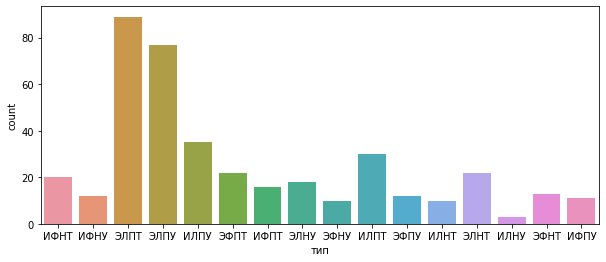

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(x="тип", data=df)

Помня о том, что каждый из 16 типов личности состоит из четырех черт, для которых есть два возможных значения, на следующем графике с кодовыми ячейками представлены круговые диаграммы, которые показывают соотношение между двумя вариантами для каждой из четырех черт.


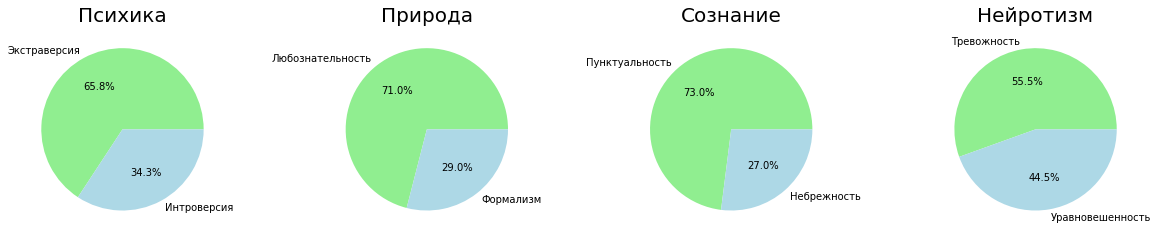

In [ ]:
type1 = df['тип'].apply(lambda x: 'Интроверсия' if x[0] == 'И' else 'Экстраверсия')
type2 = df['тип'].apply(lambda x: 'Формализм' if x[1] == 'Ф' else 'Любознательность')
type3 = df['тип'].apply(lambda x: 'Небрежность' if x[2] == 'Н' else 'Пунктуальность')
type4 = df['тип'].apply(lambda x: 'Уравновешенность' if x[3] == 'У' else 'Тревожность')

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 1)
plt.pie(type1.value_counts(), labels = type1.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax1.set_title('Психика', fontsize=20)

ax2 = plt.subplot(1, 4, 2)
plt.pie(type2.value_counts(), labels = type2.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax2.set_title('Природа', fontsize=20)

ax3 = plt.subplot(1, 4, 3)
plt.pie(type3.value_counts(), labels = type3.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax3.set_title('Сознание', fontsize=20)

ax4 = plt.subplot(1, 4, 4)
plt.pie(type4.value_counts(), labels = type4.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax4.set_title('Нейротизм', fontsize=20)
plt.show()

В следующем примере кода показано, как реализовать передискретизацию:

In [ ]:
df['психика'] = df['психика'].apply(lambda x: 0 if x == 'И' else 1)
df['природа'] = df['природа'].apply(lambda x: 0 if x == 'Ф' else 1)
df['сознание'] = df['сознание'].apply(lambda x: 0 if x == 'Н' else 1)
df['нейротизм'] = df['нейротизм'].apply(lambda x: 0 if x == 'У' else 1)

In [ ]:
df

id                                              текст  \
0      1  Начнем сначала. На картине изображено 2 лица: ...   
1      2  Здорово, дружище! Давно не виделись. У меня вс...   
2      3  Привет,  Данил! Как дела? Я надеюсь, что все х...   
3      4  На картине двое: бабушка и внук. Молодость и с...   
4      5  Привет, Маш! Как давно я не писала тебе! Все с...   
..   ...                                                ...   
395  396  Сначала я куплю себе большой дом за городом, м...   
396  397  На картине я вижу мужчину-пахаря. Он со своим ...   
397  398  Я не буду спешить с покупками. Я постараюсь вс...   
398  399  На картине изображена деревня. Женщина справа ...   
399  400  Пошел бы в лучший ресторан города, заказал то,...   

     интроверсия/экстраверсия  формализм/любознательность  \
0                          35                          44   
1                          35                          44   
2                          39                          41   
3                          39                          41   
4                          58                          70   
..                        ...                         ...   
395                        44                          45   
396                        58                          48   
397                        58                          48   
398                        39                          53   
399                        39                          53   

     небрежность/пунктуальность  уравновешенность/тревожность  психика  \
0                            38                            65        0   
1                            38                            65        0   
2                            47                            41        0   
3                            47                            41        0   
4                            58                            51        1   
..                          ...                           ...      ...   
395                          46                            40        0   
396                          61                            59        1   
397                          61                            59        1   
398                          55                            38        0   
399                          55                            38        0   

     природа  сознание  нейротизм   тип  
0          0         0          1  ИФНТ  
1          0         0          1  ИФНТ  
2          0         0          0  ИФНУ  
3          0         0          0  ИФНУ  
4          1         1          1  ЭЛПТ  
..       ...       ...        ...   ...  
395        0         0          0  ИФНУ  
396        0         1          1  ЭФПТ  
397        0         1          1  ЭФПТ  
398        1         1          0  ИЛПУ  
399        1         1          0  ИЛПУ  

[400 rows x 11 columns]

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/posts.csv')
posts2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/posts_2.csv')

In [ ]:
posts.head()

Unnamed: 0                                              текст  психика  \
0           0  URL и Intj Moment URL SportsCenter не лучшая д...        0   
1           1  Я считаю, что отсутствие меня в этом посте оче...        1   
2           2  хороший один из URL -курса, на который я говор...        0   
3           3  Уважаемый INTP, я наслаждался нашим разговором...        0   
4           4  Вы уволили, что это еще одно глупое заблуждени...        1   

   природа  сознание  нейротизм  
0        1         0          1  
1        1         1          0  
2        1         1          0  
3        1         1          1  
4        1         1          1

In [ ]:
def applyMBTI(posts):
  psych = posts['психика'].apply(lambda x: 'И' if x==0 else 'Э')
  nature = posts['природа'].apply(lambda x: 'Ф' if x==0 else 'Л')
  cogn = posts['сознание'].apply(lambda x: 'Н' if x==0 else 'П')
  neuro = posts['нейротизм'].apply(lambda x: 'У' if x==0 else 'Т')
  return psych + nature + cogn + neuro

In [ ]:
  posts['psych'] = posts['психика'].apply(lambda x: 'И' if x==0 else 'Э')
  posts['nature'] = posts['природа'].apply(lambda x: 'Ф' if x==0 else 'Л')
  posts['cogn'] = posts['сознание'].apply(lambda x: 'Н' if x==0 else 'П')
  posts['neuro'] = posts['нейротизм'].apply(lambda x: 'У' if x==0 else 'Т')

In [ ]:
posts['тип'] = posts[['psych', 'nature', 'cogn', 'neuro']].agg(''.join, axis=1)
posts = posts.drop(['psych', 'nature', 'cogn', 'neuro'], axis = 1)

In [ ]:
posts.rename(columns={'Unnamed: 0':'id'}, inplace = True)

In [ ]:
posts

id                                              текст  психика  \
0        0  URL и Intj Moment URL SportsCenter не лучшая д...        0   
1        1  Я считаю, что отсутствие меня в этом посте оче...        1   
2        2  хороший один из URL -курса, на который я говор...        0   
3        3  Уважаемый INTP, я наслаждался нашим разговором...        0   
4        4  Вы уволили, что это еще одно глупое заблуждени...        1   
...    ...                                                ...      ...   
4995  4995  Я просто хотел попробовать, и нужно было место...        0   
4996  4996  Вы уверены в этой темной мысли, кажется, из те...        0   
4997  4997  Привет всем, что я только что закончил колледж...        1   
4998  4998  не нравится говорить о моем более глубоком ощу...        1   
4999  4999  Это я чувствую то же самое в отношении моего л...        1   

      природа  сознание  нейротизм   тип  
0           1         0          1  ИЛНТ  
1           1         1          0  ЭЛПУ  
2           1         1          0  ИЛПУ  
3           1         1          1  ИЛПТ  
4           1         1          1  ЭЛПТ  
...       ...       ...        ...   ...  
4995        1         0          1  ИЛНТ  
4996        1         0          1  ИЛНТ  
4997        1         0          0  ЭЛНУ  
4998        1         0          0  ЭЛНУ  
4999        1         0          1  ЭЛНТ  

[5000 rows x 7 columns]

In [ ]:
posts2['psych'] = posts['психика'].apply(lambda x: 'И' if x==0 else 'Э')
posts2['nature'] = posts['природа'].apply(lambda x: 'Ф' if x==0 else 'Л')
posts2['cogn'] = posts['сознание'].apply(lambda x: 'Н' if x==0 else 'П')
posts2['neuro'] = posts['нейротизм'].apply(lambda x: 'У' if x==0 else 'Т')

In [ ]:
posts2['тип'] = posts2[['psych', 'nature', 'cogn', 'neuro']].agg(''.join, axis=1)
posts2 = posts2.drop(['psych', 'nature', 'cogn', 'neuro'], axis = 1)

In [ ]:
posts2

id                                              текст  психика  \
0     10001  Что ж, это, как оказалось, моя область знаний ...        0   
1     10002  Это здорово, теперь я должен записать свой гол...        1   
2     10003  Какая самая странная форма путешествия вы испы...        0   
3     10004  k Этот звук действительно действительно, но ме...        0   
4     10005  Escapism World of Warcraft Personality Cafe Чр...        1   
...     ...                                                ...      ...   
3495  13496  Для меня это обычно потому, что вы, потенциаль...        0   
3496  13497  Даже не Entp, но, черт возьми, вы, черт возьми...        0   
3497  13498  Я прочитал всю книгу, мне понравившиеся, она д...        0   
3498  13499  Я думаю, что одна вещь, которая недостаточно я...        0   
3499  13500  url intj мама, не идея, сестра Intx брат Istx ...        0   

      природа  сознание  нейротизм   тип  
0           1         0          1  ИЛНТ  
1           1         0          0  ЭЛПУ  
2           1         1          0  ИЛПУ  
3           1         0          0  ИЛПТ  
4           1         0          0  ЭЛПТ  
...       ...       ...        ...   ...  
3495        1         0          0  ЭФНТ  
3496        0         1          0  ИЛНТ  
3497        1         0          0  ИЛНТ  
3498        1         0          0  ЭЛНТ  
3499        1         1          0  ИЛПУ  

[3500 rows x 7 columns]

In [ ]:
df = df.drop(['интроверсия/экстраверсия', 'формализм/любознательность', 'небрежность/пунктуальность', 'уравновешенность/тревожность'],
             axis = 1)

In [ ]:
df = pd.concat([df, posts, posts2], axis=0)
df

id                                              текст  психика  \
0         1  Начнем сначала. На картине изображено 2 лица: ...        0   
1         2  Здорово, дружище! Давно не виделись. У меня вс...        0   
2         3  Привет,  Данил! Как дела? Я надеюсь, что все х...        0   
3         4  На картине двое: бабушка и внук. Молодость и с...        0   
4         5  Привет, Маш! Как давно я не писала тебе! Все с...        1   
...     ...                                                ...      ...   
3495  13496  Для меня это обычно потому, что вы, потенциаль...        0   
3496  13497  Даже не Entp, но, черт возьми, вы, черт возьми...        0   
3497  13498  Я прочитал всю книгу, мне понравившиеся, она д...        0   
3498  13499  Я думаю, что одна вещь, которая недостаточно я...        0   
3499  13500  url intj мама, не идея, сестра Intx брат Istx ...        0   

      природа  сознание  нейротизм   тип  
0           0         0          1  ИФНТ  
1           0         0          1  ИФНТ  
2           0         0          0  ИФНУ  
3           0         0          0  ИФНУ  
4           1         1          1  ЭЛПТ  
...       ...       ...        ...   ...  
3495        1         0          0  ЭФНТ  
3496        0         1          0  ИЛНТ  
3497        1         0          0  ИЛНТ  
3498        1         0          0  ЭЛНТ  
3499        1         1          0  ИЛПУ  

[8900 rows x 7 columns]

In [ ]:
# TO DO: translate eng to rus

In [ ]:
def removepunct(text):
  return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
def removenums(text):
  return re.sub(r'\d+', '', text)


In [ ]:
teststr = "мама, я - картин!...<>,а"

In [ ]:
teststr = teststr.translate(str.maketrans('', '', string.punctuation))
teststr

'мама я  картина'

In [ ]:
type(df['текст'])

pandas.core.series.Series

Removing nums makes model worse

In [ ]:
df['текст'] = df['текст'].str.lower()
df['текст'] = df['текст'].apply(removepunct)
# df['текст'] = df['текст'].apply(removenums)

In [ ]:
df

id                                              текст  психика  \
0         1  начнем сначала на картине изображено 2 лица мо...        0   
1         2  здорово дружище давно не виделись у меня все н...        0   
2         3  привет  данил как дела я надеюсь что все хорош...        0   
3         4  на картине двое бабушка и внук молодость и ста...        0   
4         5  привет маш как давно я не писала тебе все своб...        1   
...     ...                                                ...      ...   
3495  13496  для меня это обычно потому что вы потенциально...        0   
3496  13497  даже не entp но черт возьми вы черт возьми не ...        0   
3497  13498  я прочитал всю книгу мне понравившиеся она дей...        0   
3498  13499  я думаю что одна вещь которая недостаточно ясн...        0   
3499  13500  url intj мама не идея сестра intx брат istx не...        0   

      природа  сознание  нейротизм   тип  
0           0         0          1  ИФНТ  
1           0         0          1  ИФНТ  
2           0         0          0  ИФНУ  
3           0         0          0  ИФНУ  
4           1         1          1  ЭЛПТ  
...       ...       ...        ...   ...  
3495        1         0          0  ЭФНТ  
3496        0         1          0  ИЛНТ  
3497        1         0          0  ИЛНТ  
3498        1         0          0  ЭЛНТ  
3499        1         1          0  ИЛПУ  

[8900 rows x 7 columns]

In [ ]:
from sklearn.utils import resample

d = {}
new_train = pd.DataFrame()
class_list = df['тип'].value_counts().index
avg_class_size = int(np.average(df['тип'].value_counts()))

for mbti_type in class_list:
    d[mbti_type] = df[df['тип'] == mbti_type]
    d[mbti_type] = resample(d[mbti_type], replace = True, n_samples = avg_class_size)
    new_train = pd.concat([new_train, d[mbti_type]])

Следующие две ячейки кода определяют и вызывают функцию, которая создает диаграммы облака слов для каждого из 16 типов личности.

In [ ]:
def generate_wordcloud(text, title):
    '''
    Create and generate a word cloud image
    
    Parameters:
        text (str): The text string with all words
        title (str): The title of the word cloud
    '''
    
    wordcloud = WordCloud(background_color="white").generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize = 15)

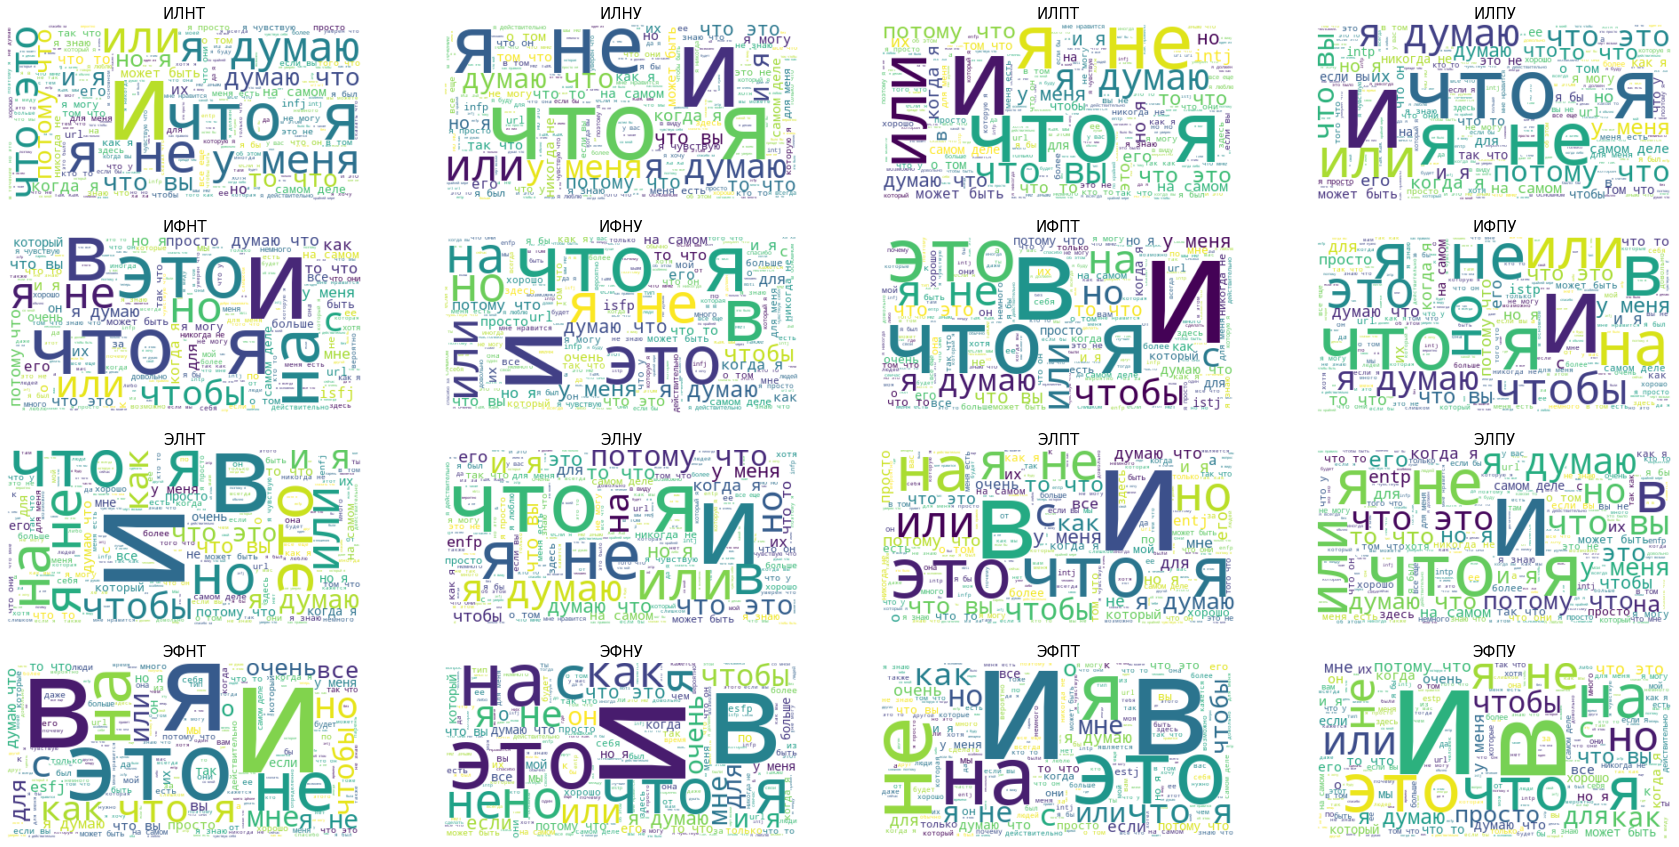

In [ ]:
train_by_personality = df.groupby("тип")['текст'].apply(' '.join).reset_index()

plt.figure(figsize=(30,15))
for i, t in enumerate(train_by_personality['тип']):
    text = train_by_personality.iloc[i,1]
    ax = plt.subplot(4, 4, i+1)
    generate_wordcloud(text, t)
plt.show()

От "облака слов" можно увидеть следующее наблюденее: необходимо избавиться от стоп-слов.

## Чистка текста

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))

#add words that aren't in the NLTK stopwords list
new_stopwords = ['очень', 'так', 'это', 'как', 'в', 'я', 'то', 'url']

stop_words.update(new_stopwords)
final_stop_words = set(stop_words)

print(final_stop_words)

{'про', 'куда', 'тут', 'ему', 'надо', 'тогда', 'или', 'сам', 'от', 'больше', 'очень', 'один', 'теперь', 'ж', 'хорошо', 'меня', 'вас', 'ним', 'потому', 'было', 'при', 'на', 'чуть', 'к', 'но', 'нет', 'нас', 'бы', 'уж', 'ну', 'это', 'ведь', 'наконец', 'моя', 'ее', 'была', 'а', 'url', 'уже', 'даже', 'чего', 'то', 'для', 'здесь', 'тоже', 'тебя', 'и', 'из', 'как', 'перед', 'всегда', 'другой', 'более', 'иногда', 'между', 'нельзя', 'вдруг', 'какой', 'будет', 'за', 'себя', 'где', 'чем', 'с', 'был', 'того', 'этот', 'вы', 'почти', 'об', 'впрочем', 'кто', 'о', 'если', 'через', 'же', 'себе', 'потом', 'него', 'хоть', 'быть', 'их', 'над', 'можно', 'мой', 'них', 'вот', 'я', 'два', 'сейчас', 'всех', 'после', 'конечно', 'зачем', 'нее', 'этом', 'ты', 'ни', 'нибудь', 'эту', 'много', 'ей', 'по', 'не', 'она', 'так', 'у', 'всю', 'тот', 'он', 'во', 'ней', 'были', 'будто', 'разве', 'ничего', 'лучше', 'вам', 'им', 'там', 'такой', 'этой', 'они', 'совсем', 'чтобы', 'опять', 'его', 'что', 'да', 'может', 'под', 'те

In [ ]:
df['очищенный текст'] = df['текст'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stop_words)]))

In [ ]:
df

id                                              текст  психика  \
0         1  начнем сначала на картине изображено 2 лица мо...        0   
1         2  здорово дружище давно не виделись у меня все н...        0   
2         3  привет  данил как дела я надеюсь что все хорош...        0   
3         4  на картине двое бабушка и внук молодость и ста...        0   
4         5  привет маш как давно я не писала тебе все своб...        1   
...     ...                                                ...      ...   
3495  13496  для меня это обычно потому что вы потенциально...        0   
3496  13497  даже не entp но черт возьми вы черт возьми не ...        0   
3497  13498  я прочитал всю книгу мне понравившиеся она дей...        0   
3498  13499  я думаю что одна вещь которая недостаточно ясн...        0   
3499  13500  url intj мама не идея сестра intx брат istx не...        0   

      природа  сознание  нейротизм   тип  \
0           0         0          1  ИФНТ   
1           0         0          1  ИФНТ   
2           0         0          0  ИФНУ   
3           0         0          0  ИФНУ   
4           1         1          1  ЭЛПТ   
...       ...       ...        ...   ...   
3495        1         0          0  ЭФНТ   
3496        0         1          0  ИЛНТ   
3497        1         0          0  ИЛНТ   
3498        1         0          0  ЭЛНТ   
3499        1         1          0  ИЛПУ   

                                        очищенный текст  
0     начнем сначала картине изображено 2 лица молод...  
1     здорово дружище давно виделись нормально продо...  
2     привет данил дела надеюсь последний месяц напр...  
3     картине двое бабушка внук молодость старость б...  
4     привет маш давно писала тебе свободное время з...  
...                                                 ...  
3495  обычно потенциальное дружелюбие угодно причиня...  
3496  entp черт возьми черт возьми намного вызовать ...  
3497  прочитал книгу понравившиеся действительно пок...  
3498  думаю одна вещь которая недостаточно ясна закл...  
3499  intj мама идея сестра intx брат istx разозлит ...  

[8900 rows x 8 columns]

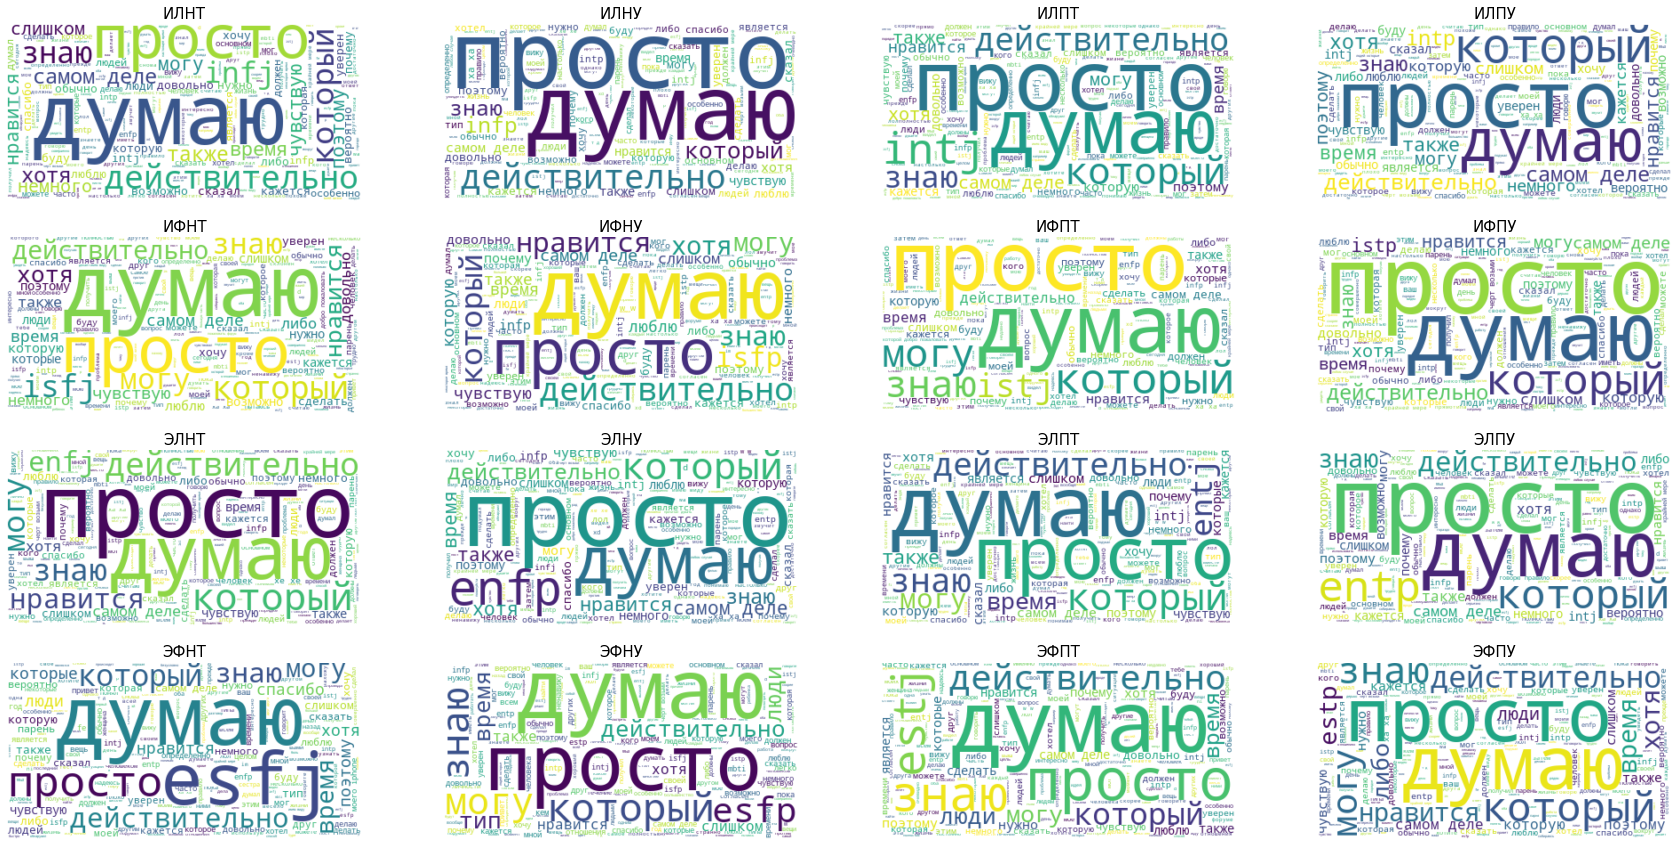

In [ ]:
train_by_personality = df.groupby("тип")['очищенный текст'].apply(' '.join).reset_index()

plt.figure(figsize=(30,15))
for i, t in enumerate(train_by_personality['тип']):
    text = train_by_personality.iloc[i,1]
    ax = plt.subplot(4, 4, i+1)
    generate_wordcloud(text, t)
plt.show()

### Векторизация и латентный семантический анализ

Векторизация данных будет проведена частотно-инверсным векторизатором частоты документа, выходом которого является матрица признаков TF-IDF.

Частота термина: обобщает, как часто данное слово появляется в тексте.  
Обратная частота документа: уменьшает количество слов, которые часто встречаются в тексте.

In [ ]:
vectorizer = TfidfVectorizer()
df_X = vectorizer.fit_transform(df['очищенный текст'])

Чтобы преодолеть проблему высокой размерности в нашей входной матрице, был выполнен латентный семантический анализ (LSA), метод уменьшения размерности, на матрице TF-IDF с использованием разложения по сингулярным значениям (SVD).

Согласно документации sklearn.decomposition.TruncatedSVD, при выполнении LSA рекомендуется n_components = 100.

In [ ]:
svd = TruncatedSVD(n_components = 100)
df_X = svd.fit_transform(df_X)

Затем мы разделяем данные на X, обучающий набор и тест.

In [ ]:
X = df_X[:6230,:]
test = df_X[6230:,:]

#### Построение целевых векторов
Взяв четыре двоичные переменные, составляющие целевой «тип», были построены следующие цели:

- Психика = 0 для интроверта и 1 для экстраверта  
- Природа = 0 для формалиста и 1 для любознательного    
- Сознание = 0 для небрежного и 1 для пунктульного  
- Нейротизм = 0 для уравновешенного и 1 для тревожного  

In [ ]:
X

array([[ 0.04803318,  0.00081875, -0.008119  , ..., -0.01247054,
         0.01415927, -0.00195711],
       [ 0.05445621, -0.01980354,  0.0017357 , ..., -0.00235021,
        -0.01076187,  0.00193502],
       [ 0.06388767, -0.04964448,  0.00427921, ...,  0.01152456,
         0.02836031,  0.01669169],
       ...,
       [ 0.18472098,  0.13643261, -0.0161721 , ..., -0.01278088,
        -0.00794227, -0.00907394],
       [ 0.19579978, -0.03216455, -0.01581164, ..., -0.05845288,
        -0.02213905,  0.00437199],
       [ 0.2426423 , -0.03309955, -0.00571886, ..., -0.01737269,
         0.012401  ,  0.02548598]])

In [ ]:
df

id                                              текст  психика  \
0         1  начнем сначала на картине изображено 2 лица мо...        0   
1         2  здорово дружище давно не виделись у меня все н...        0   
2         3  привет  данил как дела я надеюсь что все хорош...        0   
3         4  на картине двое бабушка и внук молодость и ста...        0   
4         5  привет маш как давно я не писала тебе все своб...        1   
...     ...                                                ...      ...   
3495  13496  для меня это обычно потому что вы потенциально...        0   
3496  13497  даже не entp но черт возьми вы черт возьми не ...        0   
3497  13498  я прочитал всю книгу мне понравившиеся она дей...        0   
3498  13499  я думаю что одна вещь которая недостаточно ясн...        0   
3499  13500  url intj мама не идея сестра intx брат istx не...        0   

      природа  сознание  нейротизм   тип  \
0           0         0          1  ИФНТ   
1           0         0          1  ИФНТ   
2           0         0          0  ИФНУ   
3           0         0          0  ИФНУ   
4           1         1          1  ЭЛПТ   
...       ...       ...        ...   ...   
3495        1         0          0  ЭФНТ   
3496        0         1          0  ИЛНТ   
3497        1         0          0  ИЛНТ   
3498        1         0          0  ЭЛНТ   
3499        1         1          0  ИЛПУ   

                                        очищенный текст  
0     начнем сначала картине изображено 2 лица молод...  
1     здорово дружище давно виделись нормально продо...  
2     привет данил дела надеюсь последний месяц напр...  
3     картине двое бабушка внук молодость старость б...  
4     привет маш давно писала тебе свободное время з...  
...                                                 ...  
3495  обычно потенциальное дружелюбие угодно причиня...  
3496  entp черт возьми черт возьми намного вызовать ...  
3497  прочитал книгу понравившиеся действительно пок...  
3498  думаю одна вещь которая недостаточно ясна закл...  
3499  intj мама идея сестра intx брат istx разозлит ...  

[8900 rows x 8 columns]

In [ ]:
y = df['тип'][:6230]

y_mind = y.apply(lambda x: 0 if x[0] == 'И' else 1)
y_nature = y.apply(lambda x: 0 if x[1] == 'Ф' else 1)
y_consciousness = y.apply(lambda x: 0 if x[2] == 'Н' else 1)
y_neuroticism = y.apply(lambda x: 0 if x[3] == 'У' else 1)

In [ ]:
len(X)

6230

In [ ]:
len(test)+len(X)

8900

In [ ]:
df_train = df[['id', 'текст', 'психика', 'природа', 'сознание', 'нейротизм']]
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/test.csv')

sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/random_example.csv')

# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [ ]:
df['очищенный текст'] = df['текст'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stop_words)]))

In [ ]:
vectorizer = TfidfVectorizer()
df_X = vectorizer.fit_transform(df['очищенный текст'])

In [ ]:
svd = TruncatedSVD(n_components = 100)
df_X = svd.fit_transform(df_X)

In [ ]:
df_X

array([[ 0.04838481, -0.0069774 , -0.04864128, ...,  0.00119789,
        -0.02136204,  0.02135652],
       [ 0.05445637, -0.02013458, -0.0004234 , ..., -0.00153481,
        -0.00122425, -0.00517869],
       [ 0.0640116 , -0.04903338,  0.00740147, ..., -0.01140652,
         0.01328457, -0.00024367],
       ...,
       [ 0.03045804, -0.02017017, -0.10146977, ..., -0.00454394,
        -0.01629913,  0.02625078],
       [ 0.02393959, -0.03428708, -0.12899655, ..., -0.00703858,
        -0.00406036, -0.01498852],
       [ 0.00570747, -0.00711709, -0.00335108, ...,  0.0035937 ,
         0.00704457,  0.00381599]])

In [ ]:
X = df_X[:8900,:]
test = df_X[8900:,:]

In [ ]:
len(test)

311

In [ ]:
y = df[:8900]

y_mind = y['психика']
y_nature = y['природа']
y_consciousness = y['сознание']
y_neuroticism = y['нейротизм']

In [ ]:
df

id                                              текст  психика  \
0         1  начнем сначала на картине изображено 2 лица мо...      0.0   
1         2  здорово дружище давно не виделись у меня все н...      0.0   
2         3  привет  данил как дела я надеюсь что все хорош...      0.0   
3         4  на картине двое бабушка и внук молодость и ста...      0.0   
4         5  привет маш как давно я не писала тебе все своб...      1.0   
...     ...                                                ...      ...   
9206  13807  Половину отдам на обеспечение интернатов, детс...      NaN   
9207  13808  На мой взгляд, на картине передано чувство пер...      NaN   
9208  13809  Я бы сначала последовал выражению «Кто сам не ...      NaN   
9209  13810  На картине мы видим огород. На огороде работае...      NaN   
9210  13811  Потратился на путешествия по миру. Купил бы ма...      NaN   

      природа  сознание  нейротизм  train  \
0         0.0       0.0        1.0      1   
1         0.0       0.0        1.0      1   
2         0.0       0.0        0.0      1   
3         0.0       0.0        0.0      1   
4         1.0       1.0        1.0      1   
...       ...       ...        ...    ...   
9206      NaN       NaN        NaN      0   
9207      NaN       NaN        NaN      0   
9208      NaN       NaN        NaN      0   
9209      NaN       NaN        NaN      0   
9210      NaN       NaN        NaN      0   

                                        очищенный текст  
0     начнем сначала картине изображено 2 лица молод...  
1     здорово дружище давно виделись нормально продо...  
2     привет данил дела надеюсь последний месяц напр...  
3     картине двое бабушка внук молодость старость б...  
4     привет маш давно писала тебе свободное время з...  
...                                                 ...  
9206  Половину отдам обеспечение интернатов, детских...  
9207  На взгляд, картине передано чувство переживани...  
9208  Я сначала последовал выражению «Кто дает, тому...  
9209  На картине видим огород. На огороде работает м...  
9210  Потратился путешествия миру. Купил машину, лит...  

[9211 rows x 8 columns]

## Тестирование моделей


In [ ]:
# Modules for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from mlxtend.classifier import StackingCVClassifier

# Modules for model evaluation and parameter tuning
from sklearn.model_selection import  cross_val_score, GridSearchCV

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
LogR_model = LogisticRegression()
RFC_model = RandomForestClassifier()
SVC_model = SVC(probability = True)
XGB_model = XGBClassifier()
Catboost_model = CatBoostClassifier()

category = [(y_mind, "психика"), (y_nature, "природа"), (y_consciousness, "сознание"), (y_neuroticism, "нейротизм")]
models = [(LogR_model, "LOG"), (RFC_model, "RFC"), (SVC_model, 'SVC'), (XGB_model, 'XGB'), (Catboost_model, 'CTB')]

Чтобы сравнить производительность каждой из четырех базовых моделей, был запущен следующий цикл, результаты которого приведены в таблице ниже.

In [ ]:
for a in category:
    print("-----", a[1], "-----")
    for b in models:
        score = -1*round(np.average(cross_val_score(b[0], X, a[0], cv = 4, scoring = 'neg_log_loss', n_jobs = 4)),5)
        print(b[1], ": ", score)

----- психика -----
LOG :  0.48419
RFC :  0.48496
SVC :  0.43969
XGB :  0.47716
CTB :  0.47449
----- природа -----
LOG :  0.35459
RFC :  0.36032
SVC :  0.30811
XGB :  0.32524
CTB :  0.32267
----- сознание -----
LOG :  0.51879
RFC :  0.54396
SVC :  0.46247
XGB :  0.48771
CTB :  0.4787
----- нейротизм -----
LOG :  0.58403
RFC :  0.5925
SVC :  0.54041
XGB :  0.56644
CTB :  0.55475


В таблице показаны значения Log Loss для каждой пары модель-целевая категория. Обратите внимание, что в среднем логистическая регрессия превосходит другие, в то время как XGB имеет самую низкую производительность, поэтому лучше исключить эту модель из дальнейшего рассмотрения.

## Делаем прогноз

Создание документов для проверки

В ячейке кода ниже мы определяем функцию, которая соответствует модели, прогнозирует классификацию типа личности для матрицы тренировочных данных и сохраняет файл отправки в домашнем каталоге.

In [ ]:
def submission_file(model, file_name):
    '''
    Saves to the home directory a submission file by making MBTI classificatio predictions for the test matrix using the input model.

    Parameters:
        model (sklearn model): The model used to make to make predictions
        file_name (str): The name of the file to be used.
    
    Returns:
        The function does not return an object but rather saves to the home directory a submission file.
    '''

    model.fit(X,y_mind)
    prediction_mind = pd.DataFrame(model.predict(test))
    prediction_mind.columns = ['психика']

    model.fit(X,y_nature)
    prediction_nature = pd.DataFrame(model.predict(test))
    prediction_nature.columns = ['природа']

    model.fit(X,y_consciousness)
    prediction_consciousness = pd.DataFrame(model.predict(test))
    prediction_consciousness.columns = ['сознание']

    model.fit(X,y_neuroticism)
    prediction_neuroticism = pd.DataFrame(model.predict(test))
    prediction_neuroticism.columns = ['нейротизм']
    
    submission = prediction_mind.join([prediction_nature, prediction_consciousness, prediction_neuroticism])
    submission.reset_index(inplace=True)
    submission['id'] = submission['index'] + 13501
    submission.drop('index', axis = 1, inplace = True)
    submission_df = submission[['id','психика', 'природа', 'сознание', 'нейротизм']]
    
    submission_df.to_csv(file_name, index = False)

In [ ]:
test

array([[ 0.19131869, -0.07269416, -0.28496073, ...,  0.00811291,
        -0.0046259 ,  0.03557984],
       [ 0.16875278, -0.02097741, -0.13814139, ...,  0.01098718,
        -0.00956754, -0.00444449],
       [ 0.20909572,  0.00196657, -0.11407633, ..., -0.03835278,
         0.02074835, -0.01757809],
       ...,
       [ 0.03045804, -0.02017017, -0.10146977, ..., -0.00454394,
        -0.01629913,  0.02625078],
       [ 0.02393959, -0.03428708, -0.12899655, ..., -0.00703858,
        -0.00406036, -0.01498852],
       [ 0.00570747, -0.00711709, -0.00335108, ...,  0.0035937 ,
         0.00704457,  0.00381599]])

In [ ]:
# logreg model
models = [(LogR_model, "log_submission.csv")]

for model, file_name in models:
    submission_file(model, file_name)

In [ ]:
# RFC model
models = [(RFC_model, "rfc_submission.csv")]

for model, file_name in models:
  submission_file(model, file_name)

In [ ]:
# SVC model
models = [(SVC_model, "svc_submission.csv")]

for model, file_name in models:
  submission_file(model, file_name)

In [ ]:
# Catboost model
models = [(Catboost_model, "cbt_submission.csv")]

for model, file_name in models:
  submission_file(model, file_name)

In [ ]:
testdf = pd.read_csv('/content/svc_submission.csv')
testdf

id  психика  природа  сознание  нейротизм
0    13501      0.0      1.0       0.0        0.0
1    13502      0.0      1.0       1.0        1.0
2    13503      0.0      1.0       1.0        1.0
3    13504      0.0      1.0       0.0        0.0
4    13505      0.0      1.0       1.0        0.0
..     ...      ...      ...       ...        ...
306  13807      0.0      1.0       1.0        0.0
307  13808      1.0      0.0       1.0        1.0
308  13809      0.0      1.0       1.0        0.0
309  13810      1.0      0.0       1.0        1.0
310  13811      0.0      1.0       1.0        0.0

[311 rows x 5 columns]